In [1]:
import os
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import StratifiedGroupKFold

def stratifiedgroupkfold_custom(X: pd.DataFrame, target: list, groups: list, test_size=0.2, shuffle=False, random_state=None): 
    """ 
    Creates train/test split stratified by target and grouped by groups (meaning that data from one group will be in either train or test set, but not both)
    """    
    n_splits = int(1/test_size)
    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    splits = []
    for train_idx, test_idx in sgkf.split(X, target, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        splits.append((X_train, X_test))

    return splits

In [3]:
data = pd.read_csv('data/TRIPLETS.csv')
display(data.head())

,patient_hash,patient_age,acquisition_date,laterality,frame_of_reference_UID,image_hash,image_uuid,proliferation
0,008909bd27b680698322c750c400e4b1,71,cd640cc87e74f69ede50f06adf8b4bf6,L,"{'fundus': 'cf801454541c31d5bf68f89b0f5edd1f',...","{'fundus': 'c4136c686c707e65e3fc81b33f2d46dd',...",{'fundus': 'db6a025c-bcfa-11ed-ae99-92d06df2e3...,PDR
1,008909bd27b680698322c750c400e4b1,71,cd640cc87e74f69ede50f06adf8b4bf6,L,"{'fundus': '2d4081be8cd980b8db5a1d9b8d7179ee',...","{'fundus': 'd05800dff11d5119c2641cdc68f3dfbb',...",{'fundus': 'd68d4e6a-bcfa-11ed-ae99-92d06df2e3...,PDR
2,008909bd27b680698322c750c400e4b1,71,cd640cc87e74f69ede50f06adf8b4bf6,R,"{'fundus': 'b3fc6c1fa74905b8a5e0be20fbd2c0c9',...","{'fundus': 'da5624da9427d7d91d896dfc167bcc32',...",{'fundus': 'da7a3c7c-bcfa-11ed-ae99-92d06df2e3...,PDR
3,008909bd27b680698322c750c400e4b1,71,cd640cc87e74f69ede50f06adf8b4bf6,R,"{'fundus': '4de1200c340f9080a58f2193194d087f',...","{'fundus': 'd420e06bc5a95308dbb385d90854f0a1',...",{'fundus': 'da69d6de-bcfa-11ed-ae99-92d06df2e3...,PDR
4,008909bd27b680698322c750c400e4b1,72,5a0bef51c9e6dee843fc62c0b9aceb4c,L,"{'fundus': 'abc3d225d16cd551db44b0a6d99c5491',...","{'fundus': 'cd96b74baa6ac70163eb84ee23fcbfb5',...",{'fundus': 'da9650a6-bcfa-11ed-ae99-92d06df2e3...,PDR


In [4]:
ranodm_state = 3
split_list = []

target_tv_t = [f'{row["laterality"]}_{row["proliferation"]}' for _, row in data.iterrows()]
groups_tv_t = [row['patient_hash'] for _, row in data.iterrows()]
tv_t_split = stratifiedgroupkfold_custom(data, target_tv_t, groups_tv_t, test_size=0.2, shuffle=True, random_state=ranodm_state)[0]
trainval, test = tv_t_split

target_tv = [f'{row["laterality"]}_{row["proliferation"]}' for _, row in trainval.iterrows()]
groups_tv = [row['patient_hash'] for _, row in trainval.iterrows()]
trainval_splits = stratifiedgroupkfold_custom(trainval, target_tv, groups_tv, test_size=0.2, shuffle=True, random_state=ranodm_state)

In [5]:
for i, (train, val) in enumerate(trainval_splits):
    print(f'Fold {i+1}:')
    print(f'\tTrain: {len(train)}')
    print(f'\tVal: {len(val)}')
    print(f'\tTest: {len(test)}')
    # Sanity checks
    assert len(set(train['patient_hash']).intersection(set(val['patient_hash']))) == 0
    assert len(set(train['patient_hash']).intersection(set(test['patient_hash']))) == 0
    assert len(set(val['patient_hash']).intersection(set(test['patient_hash']))) == 0
    print()

Fold 1:
	Train: 558
	Val: 148
	Test: 168

Fold 2:
	Train: 562
	Val: 144
	Test: 168

Fold 3:
	Train: 562
	Val: 144
	Test: 168

Fold 4:
	Train: 580
	Val: 126
	Test: 168

Fold 5:
	Train: 562
	Val: 144
	Test: 168



In [6]:
L_npdr = len([d for _, d in data.iterrows() if d['laterality'] == 'L' and d['proliferation'] == 'NPDR'])
L_pdr =  len([d for _, d in data.iterrows() if d['laterality'] == 'L' and d['proliferation'] == 'PDR'])
R_npdr = len([d for _, d in data.iterrows() if d['laterality'] == 'R' and d['proliferation'] == 'NPDR'])
R_pdr =  len([d for _, d in data.iterrows() if d['laterality'] == 'R' and d['proliferation'] == 'PDR'])
data_dist = [L_npdr, L_pdr, R_npdr, R_pdr]

In [7]:
L_npdr, L_pdr, R_npdr, R_pdr = {'train': [], 'val': [], 'test': []}, {'train': [], 'val': [], 'test': []}, {'train': [], 'val': [], 'test': []}, {'train': [], 'val': [], 'test': []}
for i, (train, val) in enumerate(trainval_splits):
    L_npdr['train'].append(len([d for _, d in train.iterrows() if d['laterality'] == 'L' and d['proliferation'] == 'NPDR']))
    L_npdr['val'].append(len([d for _, d in val.iterrows() if d['laterality'] == 'L' and d['proliferation'] == 'NPDR']))
    L_npdr['test'].append(len([d for _, d in test.iterrows() if d['laterality'] == 'L' and d['proliferation'] == 'NPDR']))
    L_pdr['train'].append(len([d for _, d in train.iterrows() if d['laterality'] == 'L' and d['proliferation'] == 'PDR']))
    L_pdr['val'].append(len([d for _, d in val.iterrows() if d['laterality'] == 'L' and d['proliferation'] == 'PDR']))
    L_pdr['test'].append(len([d for _, d in test.iterrows() if d['laterality'] == 'L' and d['proliferation'] == 'PDR']))
    R_npdr['train'].append(len([d for _, d in train.iterrows() if d['laterality'] == 'R' and d['proliferation'] == 'NPDR']))
    R_npdr['val'].append(len([d for _, d in val.iterrows() if d['laterality'] == 'R' and d['proliferation'] == 'NPDR']))    
    R_npdr['test'].append(len([d for _, d in test.iterrows() if d['laterality'] == 'R' and d['proliferation'] == 'NPDR']))
    R_pdr['train'].append(len([d for _, d in train.iterrows() if d['laterality'] == 'R' and d['proliferation'] == 'PDR']))
    R_pdr['val'].append(len([d for _, d in val.iterrows() if d['laterality'] == 'R' and d['proliferation'] == 'PDR']))
    R_pdr['test'].append(len([d for _, d in test.iterrows() if d['laterality'] == 'R' and d['proliferation'] == 'PDR']))

train_dist = [(np.mean(L_npdr['train']), np.std(L_npdr['train'])), (np.mean(L_pdr['train']), np.std(L_pdr['train'])), (np.mean(R_npdr['train']), np.std(R_npdr['train'])), (np.mean(R_pdr['train']), np.std(R_pdr['train']))]
val_dist = [(np.mean(L_npdr['val']), np.std(L_npdr['val'])), (np.mean(L_pdr['val']), np.std(L_pdr['val'])), (np.mean(R_npdr['val']), np.std(R_npdr['val'])), (np.mean(R_pdr['val']), np.std(R_pdr['val']))]
test_dist = [(np.mean(L_npdr['test']), np.std(L_npdr['test'])), (np.mean(L_pdr['test']), np.std(L_pdr['test'])), (np.mean(R_npdr['test']), np.std(R_npdr['test'])), (np.mean(R_pdr['test']), np.std(R_pdr['test']))]



In [8]:
print(f'Total number of triplets: {len(data)}')
print(f'\tTrain:      {sum([train_dist[i][0] for i in range(4)]):.1f} +/- {np.mean([train_dist[i][1] for i in range(4)]):.1f} ({sum([train_dist[i][0] for i in range(4)])/len(data):.1%} +/- {np.mean([train_dist[i][1] for i in range(4)])/len(data):.1%})')
print(f'\tValidation: {sum([val_dist[i][0] for i in range(4)]):.1f} +/- {np.mean([val_dist[i][1] for i in range(4)]):.1f} ({sum([val_dist[i][0] for i in range(4)])/len(data):.1%} +/- {np.mean([val_dist[i][1] for i in range(4)])/len(data):.1%})')
print(f'\tTest:       {sum([test_dist[i][0] for i in range(4)]):.1f} +/- {np.mean([test_dist[i][1] for i in range(4)]):.1f} ({sum([test_dist[i][0] for i in range(4)])/len(data):.1%})')

Total number of triplets: 874
	Train:      564.8 +/- 5.6 (64.6% +/- 0.6%)
	Validation: 141.2 +/- 5.6 (16.2% +/- 0.6%)
	Test:       168.0 +/- 0.0 (19.2%)


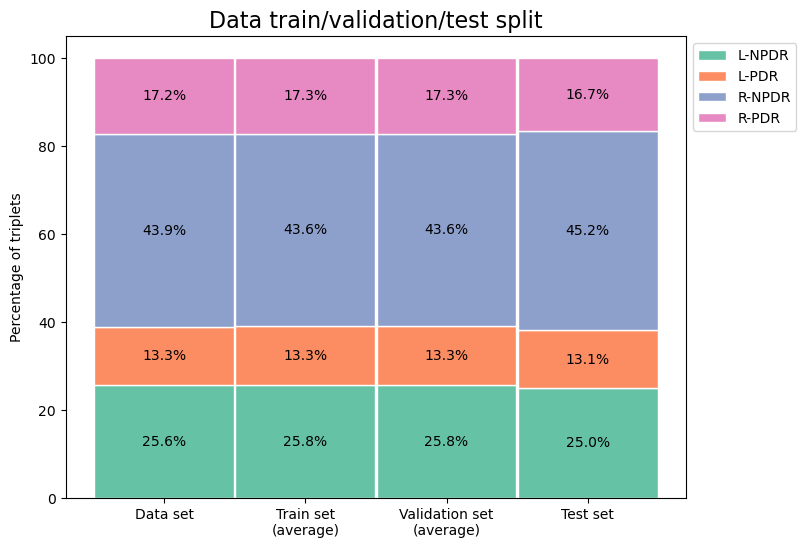

In [9]:
my_cmap = [plt.cm.get_cmap('Set2')(i) for i in range(4)]

# Stacked bar plot
fig1 = plt.figure(figsize=(8,6))
plt.title('Data train/validation/test split', fontsize=16)
dists = [data_dist, [t[0] for t in train_dist], [t[0] for t in val_dist], [t[0] for t in test_dist]]
titles = ['Data set', 'Train set\n(average)', 'Validation set\n(average)', 'Test set']
values = {t: [v/sum(d)*100 for v in d] for t, d in zip(titles, dists)}

x_axis = np.arange(len(titles))
classes = ['L-NPDR', 'L-PDR', 'R-NPDR', 'R-PDR']
bars = {t: [v[i] for v in values.values()] for i, t in enumerate(classes)}

plt.bar(x_axis, bars['L-NPDR'], label='L-NPDR', color=my_cmap[0], width=0.99, edgecolor='w')
plt.bar(x_axis, bars['L-PDR'], bottom=bars['L-NPDR'], label='L-PDR', color=my_cmap[1], width=0.99, edgecolor='w')
plt.bar(x_axis, bars['R-NPDR'], bottom=[i+j for i, j in zip(bars['L-NPDR'], bars['L-PDR'])], label='R-NPDR', color=my_cmap[2], width=0.99, edgecolor='w')
plt.bar(x_axis, bars['R-PDR'], bottom=[i+j+k for i, j, k in zip(bars['L-NPDR'], bars['L-PDR'], bars['R-NPDR'])], label='R-PDR', color=my_cmap[3], width=0.99, edgecolor='w')
for c in plt.gca().containers:
    plt.bar_label(c, fmt='%.1f%%', label_type='center')
plt.xticks(x_axis, titles)
plt.ylabel('Percentage of triplets')
plt.legend(bbox_to_anchor=(1., 1), loc='upper left')
plt.show()

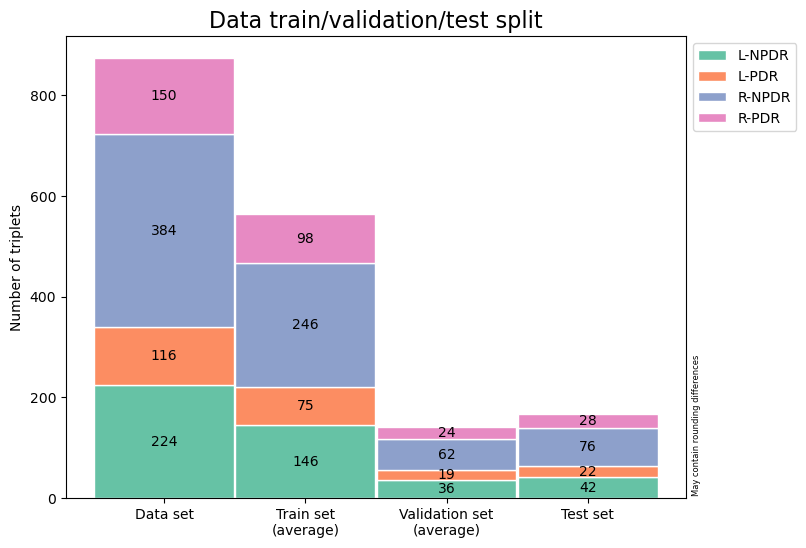

In [10]:
# Bar plot
values = {t: d for t, d in zip(titles, dists)}
bars = {t: [v[i] for v in values.values()] for i, t in enumerate(classes)}

fig2 = plt.figure(figsize=(8,6))
plt.title('Data train/validation/test split', fontsize=16)
plt.bar(x_axis, np.round(bars['L-NPDR']), label='L-NPDR', color=my_cmap[0], width=0.99, edgecolor='w')
plt.bar(x_axis, np.round(bars['L-PDR']), bottom=np.round(bars['L-NPDR']), label='L-PDR', color=my_cmap[1], width=0.99, edgecolor='w')
plt.bar(x_axis, np.round(bars['R-NPDR']), bottom=np.round([i+j for i, j in zip(bars['L-NPDR'], bars['L-PDR'])]), label='R-NPDR', color=my_cmap[2], width=0.99, edgecolor='w')
plt.bar(x_axis, np.round(bars['R-PDR']), bottom=np.round([i+j+k for i, j, k in zip(bars['L-NPDR'], bars['L-PDR'], bars['R-NPDR'])]), label='R-PDR', color=my_cmap[3], width=0.99, edgecolor='w')
for c in plt.gca().containers:
    plt.bar_label(c, label_type='center')
plt.xticks(x_axis, titles)
plt.ylabel('Number of triplets')
plt.annotate('May contain rounding differences', xy=(1.01, 0.01), xycoords='axes fraction', ha='left', rotation=90, fontsize=6)
plt.legend(bbox_to_anchor=(1., 1), loc='upper left')
plt.show()

In [11]:
# fig1.savefig('plots/split_distribution_percentage.png', bbox_inches='tight', dpi=300)
# fig2.savefig('plots/split_distribution_numbers.png', bbox_inches='tight', dpi=300)

In [12]:
# path = 'data'
# trainval = trainval.sort_values(by=['patient_hash', 'patient_age', 'acquisition_date', 'laterality'])
# trainval.to_csv(f'{path}/train.csv', index=False)
# test = test.sort_values(by=['patient_hash', 'patient_age', 'acquisition_date', 'laterality'])
# test.to_csv(f'{path}/test.csv', index=False)
# for i, (split) in enumerate(trainval_splits):
#     for df, name in zip(split, ['train', 'val']):
#         df = df.sort_values(by=['patient_hash', 'patient_age', 'acquisition_date', 'laterality'])
#         df.to_csv(f'{path}/{name}_{i+1}.csv', index=False)